# ⚠️ DO NOT EDIT THIS VERSION - PLEASE MAKE A COPY IN YOUR GOOGLE DRIVE! ⚠️

# Generate a transmission spectrum for an exoplanet atmosphere

This notebook calculates the transmission spectrum of an exoplanet atmosphere. We'll go through the different steps needed to set up the calculation, and then you can experiment with different planetary, stellar and atmospheric properties.

# 🪐 Solving Radiative Transfer in the Transmission Geometry

To calculate the transmission spectrum of an exoplanet atmosphere, we need to calculate how radiation from the star is attenuated by travelling through that atmosphere.

### 🔭 What is it we are calculating?
The observable quantity is the *transit depth*, i.e. the fraction of the star's surface area which is fully blocked by the planet. For a solid, spherical planet with no atmosphere this would just be:

$$
\Delta = \frac{R_\mathrm{p}^2}{R_\mathrm{s}^2}
$$

Where $R_\mathrm{p}$ is the radius of the planet and $R_\mathrm{p}$ is the radius of the star. When an atmosphere is present, $R_\mathrm{p}$ will be modified depending on how opaque the atmosphere is.

For a 'ring' of the atmosphere, we can use the solution to the radiative transfer equation corresponding to a slab of gas. We will be ignoring emission from the atmosphere as the stellar contribution is typically much larger. This means that the radiation from the star, $I_0$, will be attenuated as follows:

$$
I = I_0 e^{-\tau(\lambda)}
$$

where $I$ is the radiation which passes through the atmosphere and $\tau(\lambda)$ is the optical depth of the slab of gas. Note that the optical depth depends on wavelength, so our transit depth will also be wavelength-dependent!

### 🔢  How does this all add up?

We need to consider how each 'ring' of the atmosphere attenuates the light from the star, then use this to modify the original $\Delta = \frac{R_\mathrm{p}^2}{R_\mathrm{s}^2}$. The result is:

$$
\Delta = \frac{\pi R_\mathrm{p}^2 + \int_{r>R_\mathrm{p}}{2\pi r (1-e^{-\tau(\lambda,r)})dr} - \int_{r<R_\mathrm{p}}{2\pi r e^{-\tau(\lambda,r)}dr}}{\pi R_\mathrm{s}^2}
$$

Let's break this down:

1️⃣ The first integral term corresponds to 'rings' whose radii are greater than the nominal planetary radius, $R_\mathrm{p}$. In the baseline equation, $\Delta = \frac{R_\mathrm{p}^2}{R_\mathrm{s}^2}$, we assumed that these slices were completely transparent. So, this integral adds that area back on (the $\int_{r>R_\mathrm{p}}{2\pi rdr}$ term), but those slices might not be completely opaque - some stellar light is still passing through. We therefore subtract the area $\int_{r>R_\mathrm{p}}{2\pi r e^{-\tau(\lambda,r)}dr}$ to account for the light that does make it through.


 2️⃣ The second integral term is similar, but corresponds to radii less than the nominal planetary radius. These slices were already assumed to be opaque, so we're just subtracting some of the planetary area to account for light that is actually passing through this part, i.e. $\int_{r<R_\mathrm{p}}{2\pi r e^{-\tau(\lambda,r)}dr}$.



Ok, now it's time to code this up!

In [52]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
import numpy as np
import os
exo_dict = jdi.load_exo_dict()
exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well 
exo_dict['observation']['sat_unit'] = '%' 
exo_dict['observation']['noccultations'] = 2 #number of transits 
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later 
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline'] = 1.0    #fraction of time in transit versus out = in/out
exo_dict['observation']['baseline_unit'] = 'frac' 
exo_dict['observation']['noise_floor'] = 0   #this can be a fixed level or it can be a filepath 
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 8.0               #magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 5500             #in K 
exo_dict['star']['metal'] = 0.0             # as log Fe/H
exo_dict['star']['logg'] = 4.0
exo_dict['star']['radius'] = 1
exo_dict['star']['r_unit'] = 'R_sun'    
exo_dict['planet']['type'] = 'constant'
exo_dict['planet']['radius'] = 1                      #other options include "um","nm" ,"Angs", "secs" (for phase curves)
exo_dict['planet']['r_unit'] = 'R_jup'  
exo_dict['planet']['transit_duration'] = 2.0*60.0*60.0 
exo_dict['planet']['td_unit'] = 's'
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'
print('Starting TEST run')
jdi.run_pandexo(exo_dict, ['NIRSpec G140H'], save_file=False)
print('SUCCESS') 


Starting TEST run
Running Single Case for: NIRSpec G140H
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit
SUCCESS


In [53]:
import numpy as np
import scipy.constants as sc
from scipy.interpolate import RegularGridInterpolator
import astropy.constants as const
import matplotlib.pyplot as plt

# 🪐 Setting up the planetary parameters

First thing's first - we need to define the properties of our planet and star!

In [54]:
Rp = 2.733         # Planet radius in units of Earth radii
Mp = 8.41          # Planet mass in units of Earth masses

Tp = 567.0         # Temperature of the planet in Kelvin
mu = 18.0            # Mean molecular weight of the atmosphere (e.g. 2.0 for pure H2, 18.0 for pure H2O)
Pcloud = 1.0e2      # Pressure in bar of the top of a cloud deck. To remove the cloud, make this > 10 bar (because that's deeper than what the spectrum probes)
Pref = 1.0e-2       # Reference pressure in bar - we assume that the measured mass/radius and corresponding gravity are defined at this pressure

Rs = 0.216           # Stellar radius in units of solar radii


Rp *= const.R_earth.value   # Convert Rp from units of R_Earth to m
Rs *= const.R_sun.value     # Convert Rs from units of R_Sun to m
Pcloud *= 1.0e5             # Convert Pcloud from bar to Pa
Pref *= 1.0e5               # Convert Pref from bar to Pa
mu *= sc.u                  # Convert mu from atomic mass units to kg

We also need to define some arrays and properties of the atmosphere.

We will be using hydrostatic equilibrium to solve for radius (i.e. altitude) as a function of pressure:

$$
\frac{dP}{dr} = -\rho g,
$$

hence using the ideal gas law,

$$
dr = -\frac{1}{\rho g} dP = -\frac{k_B T}{\mu P g}dP = -\frac{k_B T}{\mu g}dlnP.
$$

Note also that we will be making the approximation that most of the planet's mass lies deeper than the observable part of the atmosphere. This means that graviational acceleration is proportional to $1/r^2$.

In [55]:
P = np.logspace(2.0,-5,100) * 1.0e5                                   # Define a pressure array for the atmoshpere in Pa (i.e. SI units). We're going from 100 - 1e-5 bar, i.e. 1e7 - 1 Pa.
T = Tp*np.ones_like(P)                                            # Define a corresponding temperature array for the atmosphere in Kelvin
n = P/(sc.k*T)                                                        # Number density in m^-3 - calculated using the ideal gas law
rho = mu*n                                                            # Density in kg/m^3

gp = (sc.G * Mp * const.M_earth.value) / (Rp)**2    # Planet's gravitational acceleration in m/s^2, calculated from its mass and radius (this is the value at the reference pressure)


# We'll also need to calculate radius and gravitational acceleration in the atmosphere as a function of pressure so let's initialise those arrays:

r = np.zeros_like(P)                # Radius array will be in m (set to a zero-array for now, will be populated later)
g = np.zeros_like(P)                # Gravitaional acceleration will be in m/s^2 (set to a zero-array for now, will be populated later)

# The parameters Rp and gp are defined at pressure Pref, so we need to calculate what they are at other pressures too using the equation of hydrostatic equilibrium

i_Rp = np.argmin(np.abs(P-Pref))    # Find the index where the P array gets closest to the reference pressure
r[i_Rp] = Rp                        # At that index, we set r = Rp
g[i_Rp] = gp                        # ... and g = gp

# First, let's calculate r and g for all values of r larger than Rp (note that larger i_Rp means smaller P and larger r):

for i in range(i_Rp + 1, len(P)):
  g[i] = g[i_Rp] * r[i_Rp] * r[i_Rp] / (r[i-1] * r[i-1])                              # Assuming the visible portion of the atmosphere doesn't contribute much mass to the planet, g is proportional to 1/r^2
  r[i] = r[i-1] - ( sc.k * 0.5 * (T[i-1]+T[i]) / (mu * g[i]) ) * np.log(P[i]/P[i-1])  # Use hydrostatic equilibrium to calculate the step in r. Note that P[i] < P[i-1] so dlnP is negative and r[i] > r[i-1]
# Now do the same for radii smaller than Rp:

for i in range(i_Rp-1, -1, -1):
  g[i] = g[i_Rp] * r[i_Rp] * r[i_Rp] / (r[i+1] * r[i+1])
  r[i] = r[i+1] - ( sc.k * 0.5 * (T[i+1]+T[i]) / (mu * g[i]) ) * np.log(P[i]/P[i+1])  # Same as before, but now dlnP is positive so r[i] < r[i+1]


Next, we need to calculate the opacity of the atmosphere - i.e., how it will attenuate light from the star. The opacity depends on the molecules present in the atmosphere, which absorb this radiation.

So first, we need to set the chemical composition of the atmosphere. We'll be using some of the most common molecules in hydrogen-dominated atmospheres: H$_2$, He, H$_2$O, CH$_4$, CO, CO$_2$, NH$_3$.

The amount of each molecule will be quantified by its *mixing ratio*, $X_i$, i.e. the ratio of its number density relative to the total number density. For example,

$$
X_\mathrm{H_2O} = \frac{n_\mathrm{H_2O}}{n_\mathrm{total}}.
$$

For convenience, we will actually be using the log$_{10}$ of the mixing ratio.

In [56]:
# First, set up a dictionary which will contain all the log mixing ratios, and input the abundances of all molecules except H2 and He
logX = dict()
logX['h2o'] = -3.0
logX['ch4'] = -3.0
#logX['co'] = -3.0
logX['co2'] = -3.0
#logX['nh3'] = -3.0

# We'll also need to know the mean molecular weights of each molecule (here in units of amu)
mmw = dict()
mmw['h2o'] = 18.0
mmw['h2'] = 2.0
mmw['he'] = 4.0

mmw['co2'] = 44.0
mmw['c'] = 12.0
mmw['o2'] = 32.0

mmw['ch4'] = 16.0
mmw['h4'] = 4.0

# Now we can 'fill' the rest of the atmosphere with H2 and He, which are typically the most abudnant background gases.
# Let's assume that the ratio of H2 to He is the same as that in the Sun, i.e. X_He/X_H2 = 0.17 (Asplund et al. 2009 shows that X_He/X_H = 0.085, and going from H to H2 means doubling that)
# Then X_H2 + X_He = 1 - X_rest

X_rest = np.sum([np.power(10.0,logX[key]) for key in logX.keys()])
X_H2 = (1.0 - X_rest) / (1.0 + 0.17)
X_He = 0.17 * X_H2

# Now let's add H2 and He to the logX dictionary

logX['h2'] = np.log10(X_H2)
logX['he'] = np.log10(X_He)

# With all the mixing ratios defined, we can calculate the mean molecular weight of the atmosphere, mu:
mu = 0.0
for mol in logX.keys():
  mu += np.power(10.0,logX[mol])*mmw[mol]

print("The mean molecular weight is:", mu)



The mean molecular weight is: 2.3617264957264963


Now let's calculate the opacity. We'll be using the equation for optical depth,

$$
d\tau = n \sigma ds,
$$

where n is number density, $\sigma$ is absorption cross section, $\tau$ is optical depth and $s$ is distance through the gas.

However, when we have several different molecules, we need to sum up each of their contributions to the optical depth, and this equation becomes:

$$
d\tau = \sum_i n_i \sigma_i ds,
$$

where the summation is over each molecule, $i$.

The absorption cross sections for each molecule have been measured in the lab and/or calculated theoretically by many researchers, and have been made available to the scientific community online. Note that the cross sections for a single molecule can be the subject of an entire PhD! There are several different sources of cross section data, including the [ExoMol](https://www.exomol.com/), [HITRAN](https://hitran.org/) and [HITEMP](https://hitran.org/hitemp/) databases. The [DACE opacity database](https://dace.unige.ch/opacity/?) uses ExoMol data and has a handy online plotting tool.

In [57]:
# We'll need to import some data for the absorption cross sections. You can find the files on Canvas.
# Download the files to your local machine, then upload them to this notebook with the following code:


In [58]:
h2o_temp_index = np.where(T_h2o == 500)[0][0]
print(f"Index for 500K is: {h20_temp_index}")

co2_temp_index = np.where(T_co2 == 500)[0][0]
print(f"Index for 500K is: {co2_temp_index}")

ch4_temp_index = np.where(T_ch4 == 500)[0][0]
print(f"Index for 500K is: {ch4_temp_index}")

Index for 500K is: 2
Index for 500K is: 2
Index for 500K is: 2


shape of xsec: (1584, 8, 8)
shape of lam: (1584,)
shape of P: (8,)
shape of P: (8,)


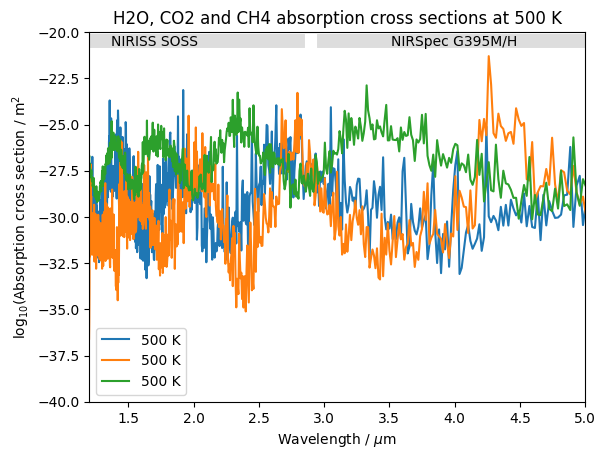

In [59]:
# Let's start by reading in a file which contains the absorption cross sections of H2O
# Note that cross sections depend on pressure, temperature and wavelength, so the cross section array is 3D!
# Also note that the values in the files are log_10(cross section)!

# Read in H2O cross section data
xsec_h2o = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/h2o_xsec.npy')
lam_h2o = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/h2o_lam.npy')*1e6 # convert to microns
P_h2o = np.power(10.0,np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/h2o_P.npy')) # already in Pa
T_h2o = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/h2o_T.npy')

# Read in CO2 cross section data
xsec_co2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/co2_xsec.npy')
lam_co2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/co2_lam.npy')*1e6 # convert to microns
P_co2 = np.power(10.0,np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/co2_P.npy')) # already in Pa
T_co2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/co2_T.npy')

# Read in CH4 cross section data
xsec_ch4 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/ch4_xsec.npy')
lam_ch4 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/ch4_lam.npy')*1e6 # convert to microns
P_ch4 = np.power(10.0,np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/ch4_P.npy')) # already in Pa
T_ch4 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/ch4_T.npy')

# H2-H2 and He-H2 molecule pairs cause absorption through a process called "collision-induced absorption". This data is wavelength- and temperature-dependent, but not pressure-dependent.
xsec_h2h2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/h2_h2_xsec.npy')
lam_h2h2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/h2_h2_lam.npy')

xsec_heh2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/he_h2_xsec.npy')
lam_heh2 = np.load('/Users/callumcroft/Exoplanets Group Project/Group-Studies---Exoplanets/GivenResources/cross_section_files/Cross_section_files/he_h2_lam.npy')

print('shape of xsec:', xsec_h2o.shape)
print('shape of lam:', lam_h2o.shape)
print('shape of P:', P_h2o.shape)
print('shape of P:', T_h2o.shape)


# Now let's plot the cross sections for H2O.
fig,ax = plt.subplots()
ax.plot(lam_h2o,xsec_h2o[:,2,h2o_temp_index], label='500 K')
ax.plot(lam_co2,xsec_co2[:,2,co2_temp_index], label='500 K')
ax.plot(lam_ch4,xsec_ch4[:,2,ch4_temp_index], label='500 K')

ax.set_xlim([1.2,5.0])
ax.set_ylim([-40,-20])
ax.set_xlabel('Wavelength / $\\mu$m')
ax.set_ylabel('log$_{10}$(Absorption cross section / m$^2$')
ax.set_title('H2O, CO2 and CH4 absorption cross sections at 500 K')

# We care about which molecular features might be visible in JWST data, so let's add the wavelength ranges of some of the different JWST instruments.

# NIRISS SOSS mode
ax.plot([0.6,2.8],[-20.5,-20.5],linewidth=10,color='#DDDDDD')
ax.text(1.7,-20.5,'NIRISS SOSS',va='center',ha='center')

# NIRSpec G395M/H modes
ax.plot([3.0,5.0],[-20.5,-20.5],linewidth=10,color='#DDDDDD')
ax.text(4,-20.5,'NIRSpec G395M/H',va='center',ha='center')

plt.legend()
plt.show()


Next, we need to define the wavelength array that we want to calculate the transmission spectrum on. With that, we can interpolate the cross sections onto the same wavelength grid and claculate the weighted sum: $\sum_i n_i \sigma_i$.

In [60]:
# Create the wavelength array in microns
lam = np.linspace(0.61,5.0,200)

log_xsec_dict = dict()

# Create wavelength–pressure mesh
lamlam, PP = np.meshgrid(lam, P, indexing="ij")

# ---- H2O ----
interp_h2o = RegularGridInterpolator(
    (lam_h2o, P_h2o, T_h2o),
    xsec_h2o,
    method='linear')
log_xsec_dict['h2o'] = interp_h2o((lamlam, PP, T[0]))

# ---- CO2 ----
interp_co2 = RegularGridInterpolator(
    (lam_co2, P_co2, T_co2),
    xsec_co2,
    method='linear'
)
log_xsec_dict['co2'] = interp_co2((lamlam, PP, T[0]))

# ---- CH4 ----
interp_ch4 = RegularGridInterpolator(
    (lam_ch4, P_ch4, T_ch4),
    xsec_ch4,
    method='linear'
)
log_xsec_dict['ch4'] = interp_ch4((lamlam, PP, T[0]))

log_cia_dict = dict()
log_cia_dict['h2h2'] = np.interp(lam, lam_h2h2, xsec_h2h2)
log_cia_dict['heh2'] = np.interp(lam, lam_heh2, xsec_heh2)

sum_nsigma = np.zeros((len(lam), len(P)))
for mol in log_xsec_dict.keys():
  sum_nsigma += n[np.newaxis,:]*np.power(10.0,logX[mol])*np.power(10.0,log_xsec_dict[mol])

# Note that for CIA, the cross section is 'per molecule^2', because the process
# requires two molecules to collide. So, we multiply by "n_i^2" instead of "n_i".

sum_nsigma += n[np.newaxis,:]*n[np.newaxis,:]*np.power(10.0,logX['h2'])*np.power(10.0,logX['h2'])*np.power(10.0,log_cia_dict['h2h2'])[:,np.newaxis]
sum_nsigma += n[np.newaxis,:]*n[np.newaxis,:]*np.power(10.0,logX['he'])*np.power(10.0,logX['h2'])*np.power(10.0,log_cia_dict['heh2'])[:,np.newaxis]


## 📈 Calculating the transmission spectrum

We've now defined the required properties of the atmosphere - we can go ahead and calculate the transmission spectrum, i.e. $\Delta = \frac{R_\mathrm{p}^2}{R_\mathrm{s}^2}$ as a function of wavelength.

We'll be using the equation stated higher up - here it is again:
$$
\Delta = \frac{\pi R_\mathrm{p}^2 + \int_{r>R_\mathrm{p}}{2\pi r (1-e^{-\tau(\lambda,r)})dr} - \int_{r<R_\mathrm{p}}{2\pi r e^{-\tau(\lambda,r)}dr}}{\pi R_\mathrm{s}^2}
$$

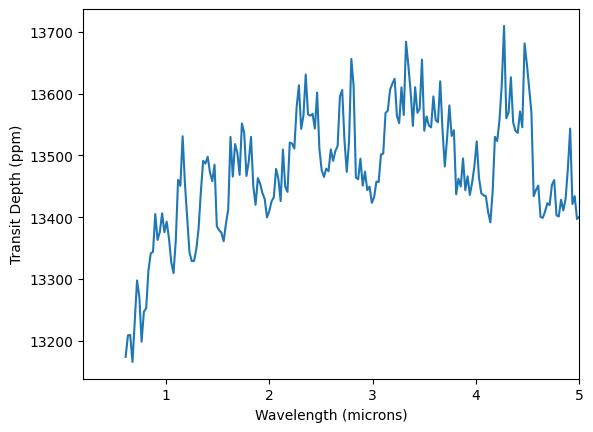

In [66]:
integral_gt_Rp = np.zeros((len(lam))) # initialise an array where we'll store the "r>Rp" integral
integral_lt_Rp = np.zeros((len(lam))) # initialise an array where we'll store the "r<Rp" integral

exptau = np.zeros((len(P),len(lam)))
transit_depth = np.zeros((len(lam)))

# Compute the total optical depth at each impact parameter and wavelength #

opacity = sum_nsigma #(kappa+sigma)
# For each layer of atmosphere

for i in range(len(r)-1):

    s_tot = np.sqrt(r[i:]*r[i:]-r[i]*r[i])
    ds = s_tot[1:]-s_tot[:-1]

    tau_tot = np.sum((opacity[:, i:-1] + opacity[:, i+1:])*ds[np.newaxis,:],axis=-1)

    # If r[i] is deeper that the top of the cloud, the atmosphere here is fully opaque and tau is very large.
    if P[i] > Pcloud:
        tau_tot += 1000.0

    # We need e^(-tau) for the integral, so let's calculate that here. Adding 1.0-e-250 avoids errors when taking the log of this in cases where e^-tau is essentially zero.
    exptau[i, :] = np.exp(-1.0*tau_tot) + 1.0e-250


# Compute transit depth terms. Note that we take an average of the i^th and (i+1)^th terms in the integrals.
for i in range(len(r)-1):

    # Rays travelling through atmosphere above Rp
    if (r[i] >= Rp):
        integral_gt_Rp[:] += 0.5*((r[i]*(1.0 - exptau[i, :]) + (r[i+1]*(1.0 - exptau[i+1, :])))*(r[i+1] - r[i]))

    # Rays travelling through atmosphere below Rp
    if (r[i] < Rp):
        integral_lt_Rp[:] += 0.5*((r[i]*(exptau[i, :]) + (r[i+1]*(exptau[i+1, :])))*(r[i+1] - r[i]))

# Compute effective transit depth (transmission spectrum) #
transit_depth[:] = (Rp*Rp + 2.0*integral_gt_Rp[:] - 2.0*integral_lt_Rp[:])/(Rs*Rs)



plt.plot(lam,transit_depth*1e6) #convert transit_depth into units of ppm
plt.xlim([0.2,5])
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (ppm)')
plt.show()

spectrum_data = np.array([lam, transit_depth]).T
np.savetxt("planet_spectrum.txt", spectrum_data)

## Next step: test the model

You just made a transmission spectrum! Now it's time to test if it makes sense (as we should always do with new code!).

Let's try reproducing a result from a paper - the 100% H2O model in Figure 2 from Kreidberg et al. 2014 (https://arxiv.org/pdf/1401.0022). You can find the parameters for GJ 1214 b in the NASA Exoplanet archive. Do you find similar features in the spectrum, and are they the right size?

In [67]:
import os

# 1. Update Planet Type to User
exo_dict['planet']['type'] = 'user'

# 2. Point to the file you just created
exo_dict['planet']['exopath'] = os.path.join(os.getcwd(), "planet_spectrum.txt")

# 3. Define the units specifically for this file
exo_dict['planet']['w_unit'] = 'um'          # Microns
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'   # Ratio (Fraction)

# 4. Make sure the timing units are set to avoid the error we saw earlier
exo_dict['planet']['td_unit'] = 's'

In [68]:
# Run the simulation
# This takes your theoretical model and adds JWST photon noise and instrument effects
result = jdi.run_pandexo(exo_dict, ['NIRSpec G395H'], save_file=True)

Running Single Case for: NIRSpec G395H
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


In [70]:
import matplotlib.pyplot as plt
import pandexo.engine.justplotit as jpi

# 1. Catch only the 3 values the function is giving you
x, y, e = jpi.jwst_1d_spec(result, R=100)

# 2. Manually grab the 'original model' from the result dictionary 
# so we can still plot the smooth line
m_x = result['spectrum']['wave']
m_y = result['spectrum']['depth']

# 3. Plotting
plt.figure(figsize=(10, 6))

# Plot original model (Truth) in ppm
plt.plot(m_x, m_y*1e6, color='black', label='Original Model', alpha=0.3)

# Plot binned data (Observation) in ppm
plt.errorbar(x, y*1e6, yerr=e*1e6, fmt='.', color='blue', 
             label='Simulated JWST Data (R=100)', markersize=5)

# 4. Clean up the "weird" vertical lines by limiting the Y-axis
# Adjust these numbers based on your expected transit depth
plt.ylim(min(m_y*1e6)-500, max(m_y*1e6)+500) 

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit Depth (ppm)')
plt.title('Corrected JWST Simulation')
plt.legend()
plt.show()

Loading BokehJS ...

KeyError: 'spectrum'